# Example 1e: Spin-Bath model (pure dephasing)

### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do the Matsubara and Pade analytical decompositions, as well as how to fit the latter with a finite set of approximate exponentials.  This differs from examble 1a in that we assume that the system and coupling parts of the Hamiltonian commute, hence giving an analytically solvable ''pure dephasing'' model. This is a useful example to look at when introducing other approximations  (e.g., fitting of correlation functions) to check for validity/convergence against the analytical results.  (Note that, generally, for the fitting examples, the pure dephasing model is the 'worst possible case'.  

### Drude-Lorentz spectral density
The Drude-Lorentz spectral density is:

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.
We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

The Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

In [1]:
import contextlib
import time

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

from qutip import *
from qutip.ipynbtools import HTMLProgressBar
from qutip.nonmarkov.heom import HEOMSolver, BosonicBath, DrudeLorentzBath, DrudeLorentzPadeBath

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

In [3]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.
    
        Each plot in plots consists of (solver_result, measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        if m_op is None:
            t, exp = result
        else:
            t = result.times
            exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(t, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [4]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:
    
        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

Here we set $H_{sys}=0$, which means the interaction Hamiltonian and the system Hamiltonian commute, and we can compare the numerical results to a known analytical one.  We could in principle keep $\epsilon \neq 0$, but it just introduces fast system oscillations, so it is more convenient to set it to zero.

In [5]:
# Defining the system Hamiltonian
eps = 0.     # Energy of the 2-level system.
Del = 0.     # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [6]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

# Bath properties:
gamma = .5 # cut off frequency
lam = .1 # coupling strength
T = 0.5
beta = 1./T

#HEOM parameters
NC = 6 # cut off parameter for the bath
Nk = 3 # number of exponents to retain in the Matsubara expansion of the correlation function

# Times to solve for
tlist = np.linspace(0, 50, 1000)

In [7]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

To get a non-trivial result we prepare the initial state in a superposition, and see how the bath destroys the coherence.

In [8]:
# Initial state of the system.
psi = (basis(2, 0) + basis(2, 1)) / np.sqrt(2.)
rho0 = psi * psi.dag()

#### Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator

In [9]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMMats = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.05000424385070801
ODE solver time: 0.5485279560089111


#### Simulation 2: Matsubara decomposition (including terminator)

In [10]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOMMatsT = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.04774665832519531
ODE solver time: 0.5990228652954102


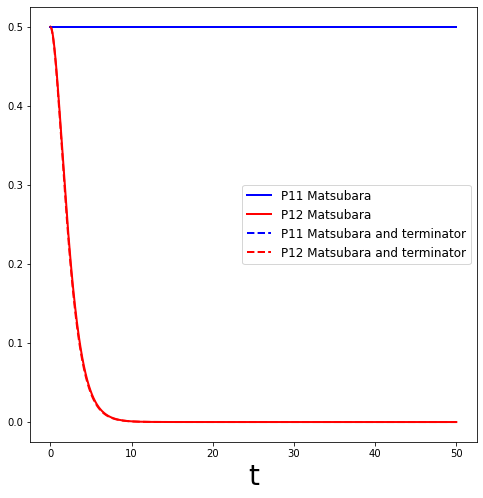

In [11]:
# Plot the results
plot_result_expectations([
    (resultMats, P11p, 'b', "P11 Matsubara"),
    (resultMats, P12p, 'r', "P12 Matsubara"),
    (resultMatsT, P11p, 'b--', "P11 Matsubara and terminator"),
    (resultMatsT, P12p, 'r--', "P12 Matsubara and terminator"),
]);

As in example 1a, we can compare to Pade and Fitting approaches.

#### Simulation 3: Pade decomposition

In [12]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMPade = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.06110191345214844
ODE solver time: 0.9042110443115234


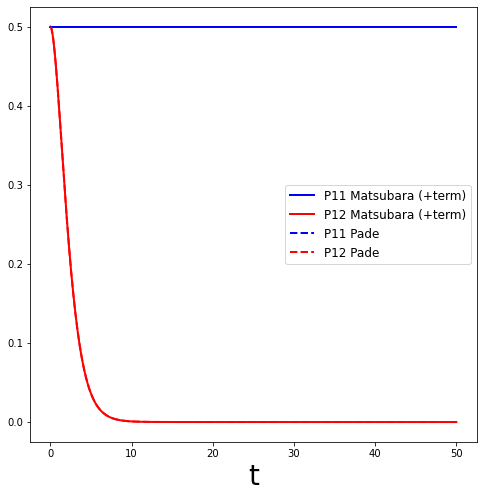

In [13]:
# Plot the results
plot_result_expectations([
    (resultMatsT, P11p, 'b', "P11 Matsubara (+term)"),
    (resultMatsT, P12p, 'r', "P12 Matsubara (+term)"),
    (resultPade, P11p, 'b--', "P11 Pade"),
    (resultPade, P12p, 'r--', "P12 Pade"),
]);

#### Simulation 4: Fitting approach

In [14]:
tlist2 = np.linspace(0, 2, 10000)
lmaxmats = 15000

def c(t, anamax):
    """Calculates real and imag. parts of the correlation function using anamax Matsubara terms"""

    result = complex(lam * gamma * (-1.0j + cot(gamma * beta / 2.)) * np.exp(-gamma * t))

    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        result += ((4 * lam * gamma * T * vk / (vk**2 - gamma**2)) * np.exp(- vk * t))

    return np.real(result), np.imag(result)

corr_ana = [c(t, lmaxmats) for t in tlist2]
corrRana, corrIana = zip(*corr_ana) # real and imag parts

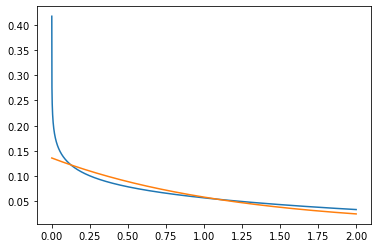

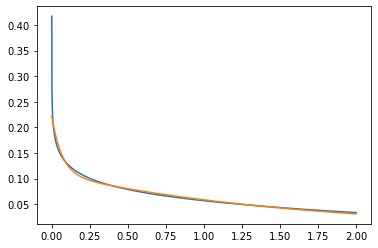

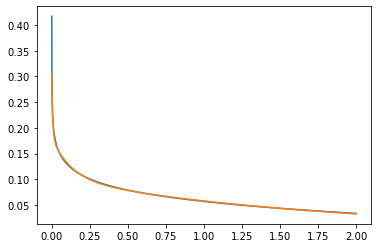

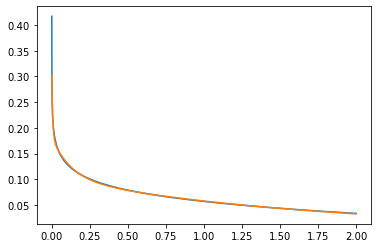

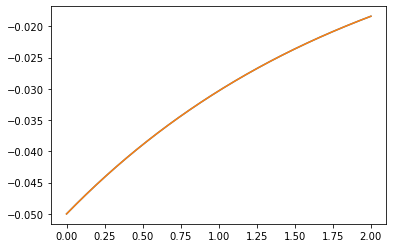

In [15]:
def wrapper_fit_func(x, N, *args):
    a, b = list(args[0][:N]), list(args[0][N:2*N])
    return fit_func(x, a, b, N)

# actual fitting function
def fit_func(x, a, b, N):
    tot = 0
    for i in range(N):
        tot += a[i]*np.exp(b[i]*x)
    return tot

def fitter(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        params_0 = [0]*(2*(i+1))
        upper_a = abs(max(ans, key = abs))*10
        #sets initial guess
        guess = []
        aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        bguess = [0]*(i+1)
        guess.extend(aguess)
        guess.extend(bguess)
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        b_lower.extend(alower)
        b_lower.extend(blower)
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0]*(i+1)
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        param_bounds = (b_lower, b_higher)
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist, ans, p0=guess, sigma=[0.01 for t in tlist], bounds = param_bounds,maxfev = 1e8)
        popt.append(p1)
        pcov.append(p2)
    return popt

# function that evaluates values with fitted params at given inputs
def checker(tlist, vals):
    y = []
    for i in tlist:
        y.append(wrapper_fit_func(i, int(len(vals)/2), vals))
    return y

# Fits of the real part with up to 4 exponents
k = 4
popt1 = fitter(corrRana, tlist2, k)
for i in range(k):
    y = checker(tlist2, popt1[i])
    plt.plot(tlist2, corrRana, tlist2, y)
    plt.show()

# Fit of the imag. part with 1 exponent
k1 = 1
popt2 = fitter(corrIana, tlist2, k1)
for i in range(k1):
    y = checker(tlist2, popt2[i])
    plt.plot(tlist2, corrIana, tlist2, y)
    plt.show()  

In [16]:
# Set the exponential coefficients from the fit parameters

ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR = [complex(x) for x in ckAR1]

vkAR1 = list(popt1[k-1])[len(list(popt1[k-1]))//2:]
vkAR = [complex(-x) for x in vkAR1]

ckAI1 = list(popt2[k1-1])[:len(list(popt2[k1-1]))//2]
ckAI = [complex(x) for x in ckAI1]

vkAI1 = list(popt2[k1-1])[len(list(popt2[k1-1]))//2:]
vkAI = [complex(-x) for x in vkAI1]

In [17]:
# Overwrite imaginary fit with analytical value just in case

ckAI = [complex(lam * gamma * (-1.0))]
vkAI = [complex(gamma)]

In [18]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
NC = 8

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMFit = HEOMSolver(Hsys, bath, NC, options=options)
    
with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.270967960357666
ODE solver time: 35.03621983528137


#### Analytic calculations

In [19]:
def pure_dephasing_evolution_analytical(tlist, wq, ck, vk):
    """
    Computes the propagating function appearing in the pure dephasing model.
        
    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.
    
    wq: float
        The qubit frequency in the Hamiltonian.

    ck: ndarray
        The list of coefficients in the correlation function.
        
    vk: ndarray
        The list of frequencies in the correlation function.
    
    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    evolution = np.array([np.exp(-1j*wq*t - correlation_integral(t, ck, vk)) for t in tlist])
    return evolution

def correlation_integral(t, ck, vk):
    """
    Computes the integral sum function appearing in the pure dephasing model.
    
    If the correlation function is a sum of exponentials then this sum
    is given by:
    
    .. math:
        
        \int_0^{t}d\tau D(\tau) = \sum_k\frac{c_k}{\mu_k^2}e^{\mu_k t}
        + \frac{\bar c_k}{\bar \mu_k^2}e^{\bar \mu_k t}
        - \frac{\bar \mu_k c_k + \mu_k \bar c_k}{\mu_k \bar \mu_k} t
        + \frac{\bar \mu_k^2 c_k + \mu_k^2 \bar c_k}{\mu_k^2 \bar \mu_k^2}
        
    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.
    
    ck: ndarray
        The list of coefficients in the correlation function.
        
    vk: ndarray
        The list of frequencies in the correlation function.
    
    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    t1 = np.sum(np.multiply(np.divide(ck, vk**2), np.exp(vk*t) - 1))
    
    t2 = np.sum(np.multiply(np.divide(np.conjugate(ck), np.conjugate(vk)**2),
                            np.exp(np.conjugate(vk)*t) - 1))
    t3 = np.sum((np.divide(ck, vk) + np.divide(np.conjugate(ck), np.conjugate(vk)))*t)

    return 2*(t1+t2-t3)

For the pure dephasing analytics, we just sum up as many matsubara terms as we can

In [20]:
lmaxmats2 =  15000

vk = [complex(-gamma)]
vk.extend([complex(-2. * np.pi * k * T) for k in range(1, lmaxmats2)])

ck = [complex(lam * gamma * (-1.0j + cot(gamma * beta / 2.)))]
ck.extend([complex(4 * lam * gamma * T * (-v) / (v**2 - gamma**2)) for v in vk[1:]])

P12_ana = 0.5 * pure_dephasing_evolution_analytical(tlist, 0, np.asarray(ck), np.asarray(vk))

Alternatively, we can just do the integral of the propagator directly, without using the correlation functions at all

In [21]:
def JDL(omega, lamc, omega_c):
    return 2. * lamc * omega * omega_c / (omega_c**2 + omega**2)

def integrand(omega, lamc, omega_c, Temp, t):
    return (-4. * JDL(omega,lamc,omega_c) / omega**2) * (1. - np.cos(omega*t)) * (coth(omega/(2.*Temp))) / np.pi

P12_ana2 = [0.5 * np.exp(sp.integrate.quad(integrand, 0., np.inf, args=(lam,gamma,T,t,))[0]) for t in tlist]

/tmp/ipykernel_5094/4088145471.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P12_ana2 = [0.5 * np.exp(sp.integrate.quad(integrand, 0., np.inf, args=(lam,gamma,T,t,))[0]) for t in tlist]


#### Compare results

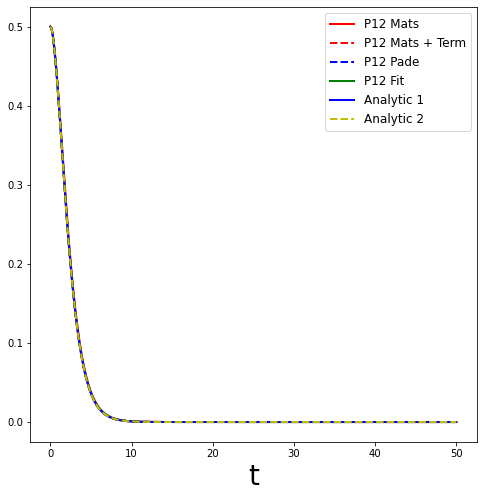

In [22]:
plot_result_expectations([
    (resultMats, P12p, 'r', "P12 Mats"),
    (resultMatsT, P12p, 'r--', "P12 Mats + Term"),
    (resultPade, P12p, 'b--', "P12 Pade"),
    (resultFit, P12p, 'g', "P12 Fit"),
    ((tlist, np.real(P12_ana)), None, 'b', "Analytic 1"),
    ((tlist, np.real(P12_ana2)), None, 'y--', "Analytic 2"),
]);

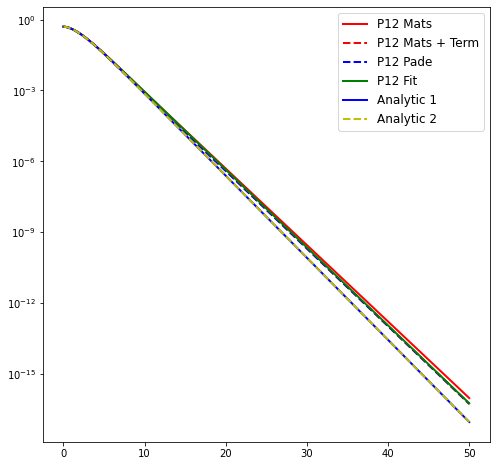

In [23]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

plot_result_expectations([
    (resultMats, P12p, 'r', "P12 Mats"),
    (resultMatsT, P12p, 'r--', "P12 Mats + Term"),
    (resultPade, P12p, 'b--', "P12 Pade"),
    (resultFit, P12p, 'g', "P12 Fit"),
    ((tlist, np.real(P12_ana)), None, 'b', "Analytic 1"),
    ((tlist, np.real(P12_ana2)), None, 'y--', "Analytic 2"),
], axes)

axes.set_yscale('log')
axes.legend(loc=0, fontsize=12)
pass

In [24]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.0.dev0+b71625e
Numpy,1.21.2
SciPy,1.7.1
matplotlib,3.5.0
Cython,0.29.25
Number of CPUs,6
BLAS Info,INTEL MKL
IPython,7.29.0
Python,"3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]"
OS,posix [linux]
